In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import datetime

In [2]:
#empty lists to hold data
title_list = []
date_list = []
reviews_list = []
recommended_list = []

#scrape all British Airways reviews from Airline Quality website
def scrape_pages():
    for page in range(1,77):
        url = f'https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/?sortby=post_date%3ADesc&pagesize=50'
        response = requests.get(url)
        content = response.content
        soup = BeautifulSoup(content, "html.parser")
        reviews = soup.find_all('article', itemprop ='review')
        for review in reviews:
            #add review title
            review_title = review.find('h2').text
            title_list.append(review_title)
            #add review date
            date = review.find('time')
            date_time = date.attrs["datetime"]
            date_list.append(date_time)
            #add review test
            review_text = review.find('div', class_ = 'text_content').text
            reviews_list.append(review_text) 
            #add whether reviewer would recommend British Airways
            recommended = review.find_all('td')[-1].text
            recommended_list.append(recommended)
    #return as DataFrame 
    return pd.DataFrame({"Title" : title_list, "Review Date" : date_list, "Review" : reviews_list,
                    "Recommended" : recommended_list})

In [ ]:
#apply function 
df = scrape_pages()

In [ ]:
#save dataframe to csv
df.to_csv("british_airways.csv")

In [18]:
#read csv file and drop unnecessary column
df = pd.read_csv("british_airways.csv")
df.drop(columns = "Unnamed: 0", axis = 1, inplace = True)

In [19]:
#info about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        3785 non-null   object
 1   Review Date  3785 non-null   object
 2   Review       3785 non-null   object
 3   Recommended  3785 non-null   object
dtypes: object(4)
memory usage: 118.4+ KB


In [8]:
df.head()

,Title,Review Date,Review,Recommended
0,"""The flights were okay""",2024-04-12,✅ Trip Verified | We chose Rotterdam and Lond...,no
1,“entire experience has been stressful”,2024-04-10,✅ Trip Verified | The entire booking and ticke...,no
2,"""whole experience was awful""",2024-04-10,Not Verified | British Airways cancelled my ...,no
3,“This is true service”,2024-04-07,Not Verified | I wanted to write this review s...,yes
4,"""Flight attendants welcoming""",2024-04-03,✅ Trip Verified | Check in fast and friendly....,yes


In [20]:
#convert Review Date column to datetime 
df["Review Date"] = df["Review Date"].astype("datetime64[ns]")

In [21]:
#add year column
df["year"] = df["Review Date"].dt.year

<Axes: title={'center': 'British Airways Recommendation Percentages'}, ylabel='Recommended'>

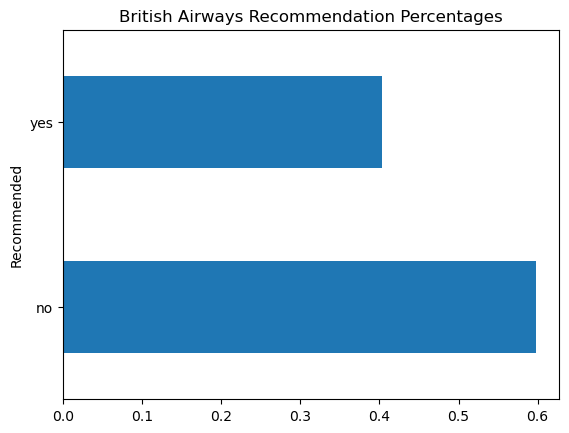

In [6]:
#look at value counts
df["Recommended"].value_counts(normalize=True).plot(kind="barh", title = "British Airways Recommendation Percentages")

# About 60 percent of reviews would not recommend British Airways

<Axes: title={'center': 'British Airways Review Count by Year'}, xlabel='year'>

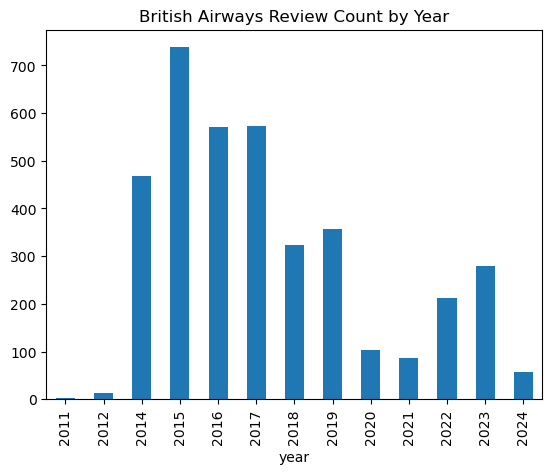

In [7]:
df["year"].value_counts().sort_index().plot(kind="bar", title = "British Airways Review Count by Year")

In [30]:
#create copy of dataframe

reviews = df.copy()


In [32]:
#remove 'trip verified' and 'not verified' markers at the beginning of each review
reviews["Review"] = reviews["Review"].str.split("|", expand = True)[1]

In [34]:
empty = reviews["Review"].isna()

In [36]:
empty = pd.DataFrame(empty)

In [37]:
test = empty[empty["Review"] == True]
empty_list = test.index.tolist()

In [39]:
non_verified = df[df.index.isin(empty_list)]

In [40]:
verified = reviews.dropna()

In [41]:
frames = [verified, non_verified]

all_reviews = pd.concat(frames)

In [44]:
all_reviews.tail()

,Title,Review Date,Review,Recommended,year
3780,British Airways customer review,2012-08-29,This was a bmi Regional operated flight on a R...,no,2012
3781,British Airways customer review,2012-08-28,LHR to HAM. Purser addresses all club passenge...,yes,2012
3782,British Airways customer review,2011-10-12,My son who had worked for British Airways urge...,yes,2011
3783,British Airways customer review,2011-10-11,London City-New York JFK via Shannon on A318 b...,no,2011
3784,British Airways customer review,2011-10-09,SIN-LHR BA12 B747-436 First Class. Old aircraf...,no,2011


In [45]:
#looking at the distribution of reviews across years
all_reviews["year"].value_counts(normalize=True)

#most of the reviews are from between 2014-2019

year
2015    0.194980
2017    0.151123
2016    0.150594
2014    0.123646
2019    0.094055
2018    0.085601
2023    0.073976
2022    0.056275
2020    0.027477
2021    0.022985
2024    0.015324
2012    0.003170
2011    0.000793
Name: proportion, dtype: float64

In [46]:
#percentage of reviews that recommonded British Airways each year
all_reviews.groupby(by="year")["Recommended"].value_counts(normalize=True)


year  Recommended
2011  no             0.666667
      yes            0.333333
2012  no             0.500000
      yes            0.500000
2014  yes            0.568376
      no             0.431624
2015  yes            0.512195
      no             0.487805
2016  no             0.556140
      yes            0.443860
2017  no             0.744755
      yes            0.255245
2018  no             0.679012
      yes            0.320988
2019  no             0.592697
      yes            0.407303
2020  no             0.634615
      yes            0.365385
2021  no             0.597701
      yes            0.402299
2022  no             0.680751
      yes            0.319249
2023  no             0.767857
      yes            0.232143
2024  no             0.672414
      yes            0.327586
Name: proportion, dtype: float64

In [48]:
df2 = all_reviews

In [49]:
#looking through reviews for key words to categorize reviews 
#grouping reviews that mention anything about 'service', 'food', 'wifi' or 'delays/cancellations'
df2.loc[df2['Review'].str.contains('flight attendants|flight attendant|cabin crew|crew|service', case=False, na=False), 'Service'] = "Yes"
df2.loc[df2["Review"].str.contains('meals|food|menu|drinks|meal', case = False, na = False), 'Food'] = "Yes"
df2.loc[df2["Review"].str.contains('wifi|wi-fi', case=False, na=False), 'Wifi'] = "Yes"
df2.loc[df2['Review'].str.contains('late|delay|cancellation', case=False, na=False), 'Delays_Cancellations'] = "Yes"


In [50]:
#replace 'none' values with 'no'
df2[["Service", "Food", "Wifi", "Delays_Cancellations"]] = df2[["Service", "Food", "Wifi", "Delays_Cancellations"]].replace({"nan" : "No"})


In [65]:
#create dataframes containing reviews specific to each category
service = df2[df2["Service"] == "Yes"]
food = df2[df2["Food"] == "Yes"]
delays = df2[df2["Delays_Cancellations"] == "Yes"]
wifi = df2[df2["Wifi"] == "Yes"]

In [53]:
#importing modules to prepare for sentiment analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adaml\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adaml\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adaml\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
import re

# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

In [55]:
#apply function to reviews
df2['Cleaned Review'] = df2['Review'].apply(clean)

In [56]:
#import sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# function to calculate vader sentiment and apply it to reviews
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df2['Sentiment'] = df2['Cleaned Review'].apply(vadersentimentanalysis)

In [57]:
#create function to determine if review is positive, negative, or neutral and apply it to sentiment score
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df2['Analysis'] = df2['Sentiment'].apply(vader_analysis)

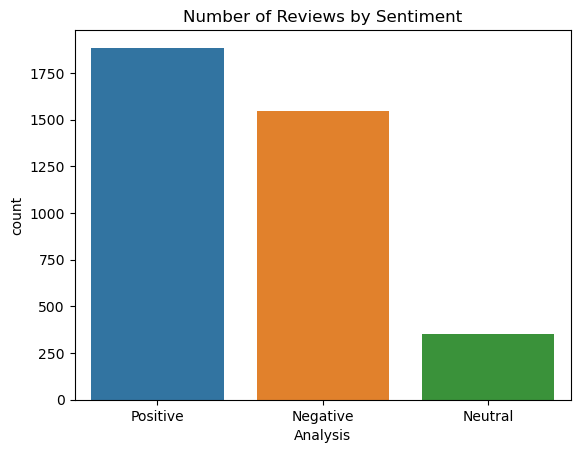

In [61]:
#plot graph to show number of reviews by positive, negative, and neutral sentiment
sns.countplot(df2, x = "Analysis")
plt.title("Number of Reviews by Sentiment")
plt.show()

In [59]:
#review sentiment by year, shows that reviews are becoming increasingly negative
test = df2.groupby(by="year")["Analysis"].value_counts(normalize=True)
test = pd.DataFrame(test)
test

proportion
year Analysis            
2011 Positive    0.666667
     Neutral     0.333333
2012 Positive    0.583333
     Negative    0.250000
     Neutral     0.166667
2014 Positive    0.628205
     Negative    0.299145
     Neutral     0.072650
2015 Positive    0.560976
     Negative    0.334688
     Neutral     0.104336
2016 Positive    0.545614
     Negative    0.373684
     Neutral     0.080702
2017 Negative    0.463287
     Positive    0.442308
     Neutral     0.094406
2018 Positive    0.478395
     Negative    0.435185
     Neutral     0.086420
2019 Positive    0.488764
     Negative    0.421348
     Neutral     0.089888
2020 Negative    0.442308
     Positive    0.423077
     Neutral     0.134615
2021 Negative    0.471264
     Positive    0.413793
     Neutral     0.114943
2022 Negative    0.492958
     Positive    0.399061
     Neutral     0.107981
2023 Negative    0.600000
     Positive    0.307143
     Neutral     0.092857
2024 Negative    0.517241
     Positive    0.431034
     Neutral     0.051724

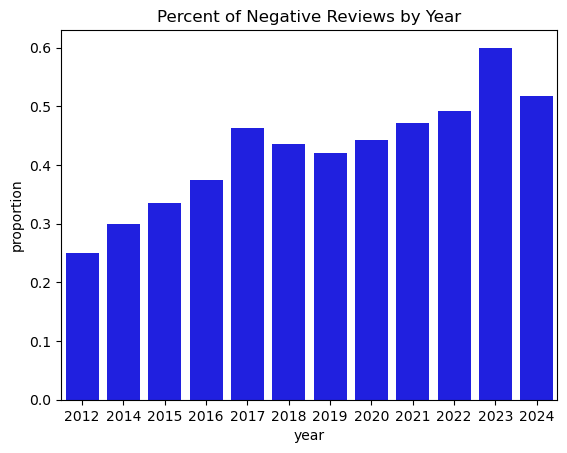

In [60]:
#plot to show percentage of negative reviews by year
test2 = test.reset_index()
info = test2[test2["Analysis"] == "Negative"]
sns.barplot(data = info, x = "year" , y = "proportion", color = "blue")
plt.title("Percent of Negative Reviews by Year")
plt.show()

In [69]:
#create wordcloud to show most common words in reviews

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

words = wifi["Cleaned Review"]

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

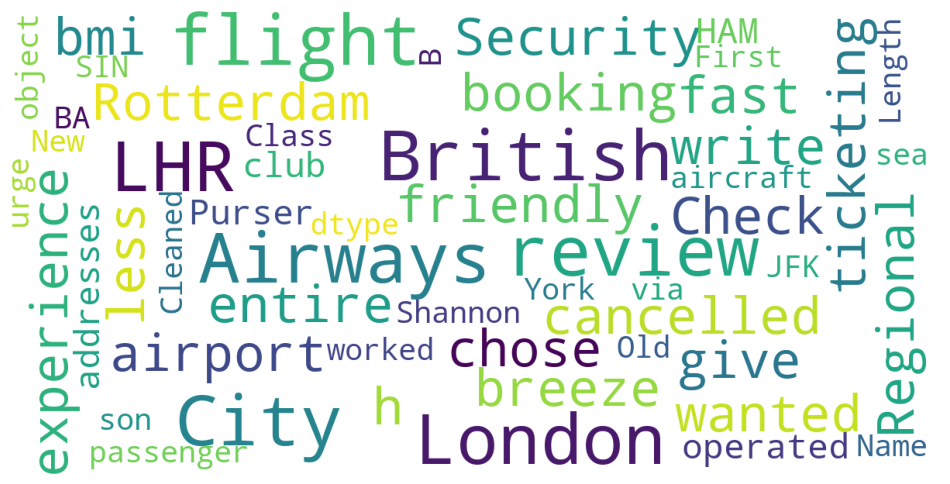

In [64]:
total_reviews = show_wordcloud(words)